# Executive Summary

Cyclistic’s pricing structure creates a clear imbalance between members and casual riders. Members effectively pay 3.8 cents per minute once their annual fee is spread across the time they actually ride. This is the per‑minute value that makes a member financially equivalent to a casual rider, even though members pay nothing for the first 45 minutes of each trip. The member plan delivers far more value than its price suggests.

I also examine a pricing corridor from 4 to 12 cents per minute, which reflects typical rates in comparable mobility services. Under current rider behaviour, every price in this corridor generates less revenue than the current casual rate of 19 cents per minute. These projections assume that riders do not change their behaviour when prices change. Research on ride‑share markets shows this assumption is unrealistic. Demand is price elastic, and riders adjust their usage when prices shift. Because Cyclistic’s dataset contains no variation in price, this analysis cannot estimate elasticity or predict how ridership would change under new prices.

The strategic implication is clear. Cyclistic’s revenue challenge stems from an underpriced member plan, not from casual pricing. To design an effective pricing strategy — one that balances revenue, ridership, and membership conversion — Cyclistic needs behavioural data. A controlled price experiment would provide the evidence needed to understand how riders respond to different prices and to set rates that reflect both financial goals and real‑world behaviour.

# Why Bayesian?

A Bayesian approach quantifies uncertainty directly. Instead of asking “What is the average?”, Bayesian modelling asks “How confident are we, and what range of outcomes is plausible?” This matters for bike‑share data, where trip durations and revenues are skewed and variable. By modelling full probability distributions, we gain clearer insight into rider behaviour, stronger comparisons between members and casual riders, and estimates that reflect real‑world uncertainty.

# 0. Setup

This section prepares the dataset for modelling. It loads the cleaned Cyclistic data, recreates key engineered variables, and builds subsets for duration and revenue analysis.

## 0.1 Imports

In [1]:
# import warnings
# warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns


/home/ndrew/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


## 0.2 Load the Cleaned Dataset

In [2]:
df = pd.read_csv("cyclistic_cleaned.csv", parse_dates=["started_at", "ended_at"])

## 0.3 Recreate Analytical Variables

In [3]:
# Trip duration in minutes
df["trip_duration_min"] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60
df = df[df["trip_duration_min"] > 0]

# Temporal features
df["is_weekend"] = df["started_at"].dt.dayofweek >= 5
df["hour"] = df["started_at"].dt.hour
df["is_peak"] = df["hour"].between(7, 9) | df["hour"].between(16, 18)


## 0.4 Create Member and Casual Subsets

In [4]:
members = df[df["member_casual"] == "member"]["trip_duration_min"]
casuals = df[df["member_casual"] == "casual"]["trip_duration_min"]


## 0.5 Revenue Variables

In [5]:
R = 0.19  # per-minute casual rate
F = 45    # free minutes for hypothetical member overage

casual_df = df[df["member_casual"] == "casual"].copy()
casual_df["trip_revenue"] = casual_df["trip_duration_min"] * R


## 0.6 Prepare Features for Logistic Regression (Future Extension)

In [6]:
df_bayes = df.copy()
df_bayes["target"] = (df_bayes["member_casual"] == "member").astype(int)

X = df_bayes[["trip_duration_min", "is_weekend", "is_peak"]]
y = df_bayes["target"].values


# 1. Model 1 — Trip Duration Differences

Cyclistic riders fall into two groups: members and casual riders. Their behaviour differs in clear ways, and trip duration is one of the strongest signals. This model estimates how much longer casual riders ride, and how certain we are about that difference.

Trip durations are positive and skewed. Most rides are short; a few run long. A log‑normal model fits this pattern well. I model the log of each duration and estimate separate means for members and casual riders. The difference between these means tells us how much longer casual riders ride.

## 1.1 Prepare Data for the Duration Model

In [7]:
members_log = np.log(members)
casuals_log = np.log(casuals)

n_m = len(members_log)
n_c = len(casuals_log)

mean_m = members_log.mean()
mean_c = casuals_log.mean()

var_m = members_log.var(ddof=1)
var_c = members_log.var(ddof=1)


In [14]:
# Calculate typical member ride duration
member_typical = df.loc[df["member_casual"] == "member", "trip_duration_min"].median()
member_typical

np.float64(8.72275)

## 1.2 Bayesian Duration Model

In [8]:
import pytensor.tensor as pt

with pm.Model() as duration_model:

    mu_member = pm.Normal("mu_member", mu=0, sigma=10)
    mu_casual = pm.Normal("mu_casual", mu=0, sigma=10)
    sigma_member = pm.HalfNormal("sigma_member", sigma=5)
    sigma_casual = pm.HalfNormal("sigma_casual", sigma=5)

    ss_m = (n_m - 1) * var_m + n_m * (mean_m - mu_member)**2
    pm.Potential(
        "ll_member",
        -0.5 * n_m * pt.log(2 * np.pi * sigma_member**2)
        - ss_m / (2 * sigma_member**2)
    )

    ss_c = (n_c - 1) * var_c + n_c * (mean_c - mu_casual)**2
    pm.Potential(
        "ll_casual",
        -0.5 * n_c * pt.log(2 * np.pi * sigma_casual**2)
        - ss_c / (2 * sigma_casual**2)
    )

    diff = pm.Deterministic("diff", mu_casual - mu_member)

    duration_trace = pm.sample(2000, tune=2000, target_accept=0.9, cores=4)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_member, mu_casual, sigma_member, sigma_casual]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


## 1.3 Posterior Difference in Trip Duration

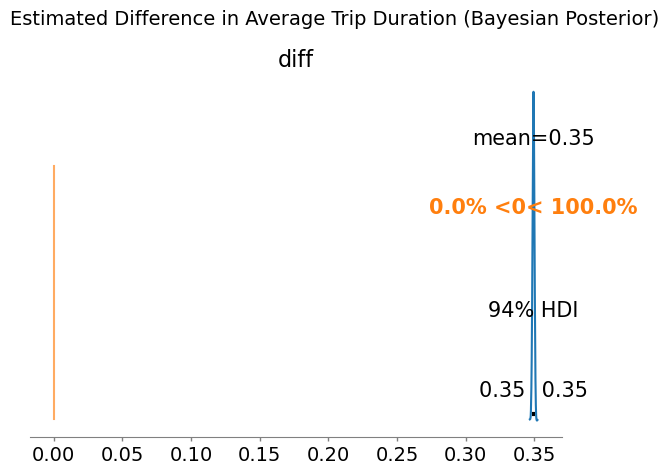

In [9]:
ax = az.plot_posterior(duration_trace, var_names=["diff"], ref_val=0)
fig = ax.figure
fig.suptitle("Estimated Difference in Average Trip Duration (Bayesian Posterior)", fontsize=14)
plt.tight_layout()


### Interpretation:  
The posterior distribution is entirely above zero.
The model assigns essentially a 100% probability that casual riders take longer trips.

## 1.4 Convert the Difference to Minutes

In [10]:
diff_samples = duration_trace.posterior["diff"].values.flatten()
ratio_samples = np.exp(diff_samples)

ratio_mean = ratio_samples.mean()
hdi_low, hdi_high = np.quantile(ratio_samples, [0.03, 0.97])

ratio_mean, hdi_low, hdi_high


(np.float64(1.4183199746129593),
 np.float64(1.4164493069587016),
 np.float64(1.4201622768578492))

### Interpretation:  
Casual riders take 1.42 times longer trips than members.
A typical member trip lasts 8.7 minutes.
A typical casual trip therfore lasts 12.4 minutes — about 3.6 minutes longer.

## 1.5 Posterior Predictive Check

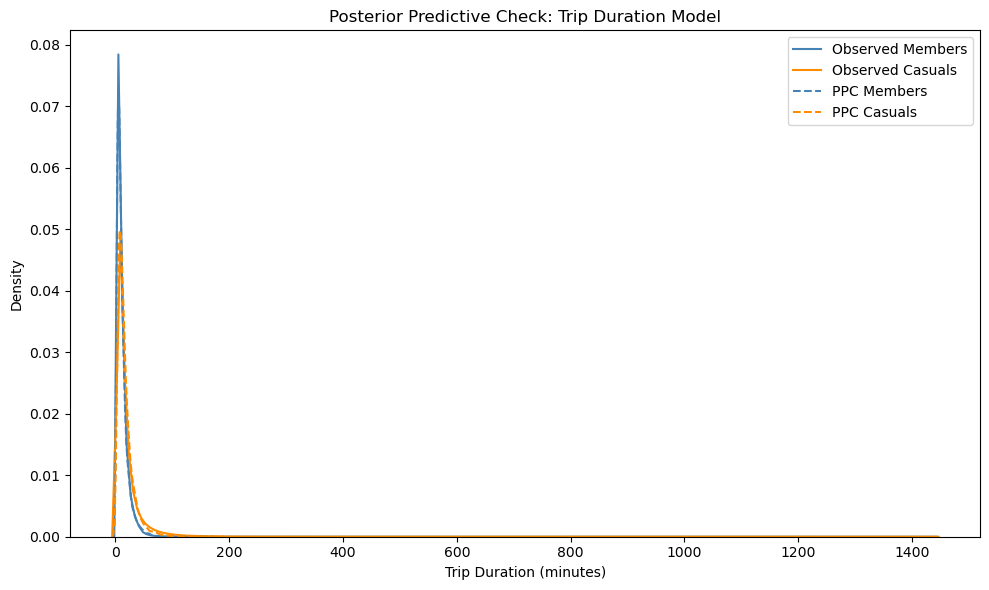

In [11]:
mu_member_samples = duration_trace.posterior["mu_member"].values.flatten()
mu_casual_samples = duration_trace.posterior["mu_casual"].values.flatten()
sigma_member_samples = duration_trace.posterior["sigma_member"].values.flatten()
sigma_casual_samples = duration_trace.posterior["sigma_casual"].values.flatten()

ppc_member = np.exp(np.random.normal(mu_member_samples, sigma_member_samples))
ppc_casual = np.exp(np.random.normal(mu_casual_samples, sigma_casual_samples))

plt.figure(figsize=(10, 6))

sns.kdeplot(members, label="Observed Members", color="steelblue")
sns.kdeplot(casuals, label="Observed Casuals", color="darkorange")

sns.kdeplot(ppc_member, label="PPC Members", color="steelblue", linestyle="--")
sns.kdeplot(ppc_casual, label="PPC Casuals", color="darkorange", linestyle="--")

plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Density")
plt.title("Posterior Predictive Check: Trip Duration Model")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation:  
The model reproduces the shape of the observed data well.
This gives confidence in the duration estimates.

# 2. Model 2 — Revenue Modelling for Casual Riders

Cyclistic earns most of its revenue from casual riders. Understanding this revenue is essential for evaluating the financial impact of converting casual riders to members. Casual revenue is skewed and variable, so a Bayesian model is well‑suited to estimate its distribution and quantify uncertainty.

This model answers two questions:

- How much revenue does Cyclistic earn from a typical casual trip?

- What happens to revenue if casual riders become members?

## 2.1 Prepare Revenue Data

In [12]:
casual_df = df[df['member_casual'] == 'casual'].copy()
R = 0.19

casual_df['trip_revenue'] = casual_df['trip_duration_min'] * R
casual_df = casual_df[casual_df['trip_revenue'] > 0].copy()
casual_df['log_trip_revenue'] = np.log(casual_df['trip_revenue'])


## 2.2 Bayesian Revenue Model

In [15]:
log_revenue_data = casual_df['log_trip_revenue'].values

with pm.Model() as revenue_model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    log_rev = pm.Normal("log_rev", mu=mu, sigma=sigma, observed=log_revenue_data)

    expected_revenue = pm.Deterministic("expected_revenue", pm.math.exp(mu))

    revenue_trace = pm.sample(2000, tune=2000, target_accept=0.9)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 382 seconds.


## 2.3 Posterior Summary

In [16]:
az.summary(revenue_trace, var_names=["mu", "sigma", "expected_revenue"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.862,0.001,0.861,0.863,0.0,0.0,6706.0,5377.0,1.0
sigma,0.892,0.000,0.891,0.893,0.0,0.0,8466.0,5391.0,1.0
expected_revenue,2.368,0.002,2.365,2.371,0.0,0.0,6706.0,5377.0,1.0


### Interpretation:  
Cyclistic earns about $2.37 per casual trip.
The credible interval is narrow and stable.

## 2.4 Total Revenue from Casual Riders

In [17]:
actual_total_revenue = casual_df['trip_revenue'].sum()
actual_total_revenue


np.float64(7278053.969038667)

Cyclistic earns about $7.28 million from casual riders.

## 2.5 Hypothetical Revenue Under the Member Plan

In [18]:
F = 45
R = 0.19

casual_df['member_overage'] = np.maximum(casual_df['trip_duration_min'] - F, 0)
casual_df['member_revenue'] = casual_df['member_overage'] * R

hypothetical_total_revenue = casual_df['member_revenue'].sum()
hypothetical_total_revenue


np.float64(1356348.2204296666)

Under the member plan, the same rides would earn about $1.36 million.

## 2.6 Revenue Impact of Converting Casual Riders to Members

In [19]:
revenue_change = hypothetical_total_revenue - actual_total_revenue
revenue_change


np.float64(-5921705.748609001)

Cyclistic would lose about $5.9 million in revenue.

## 2.7 Visual Comparison

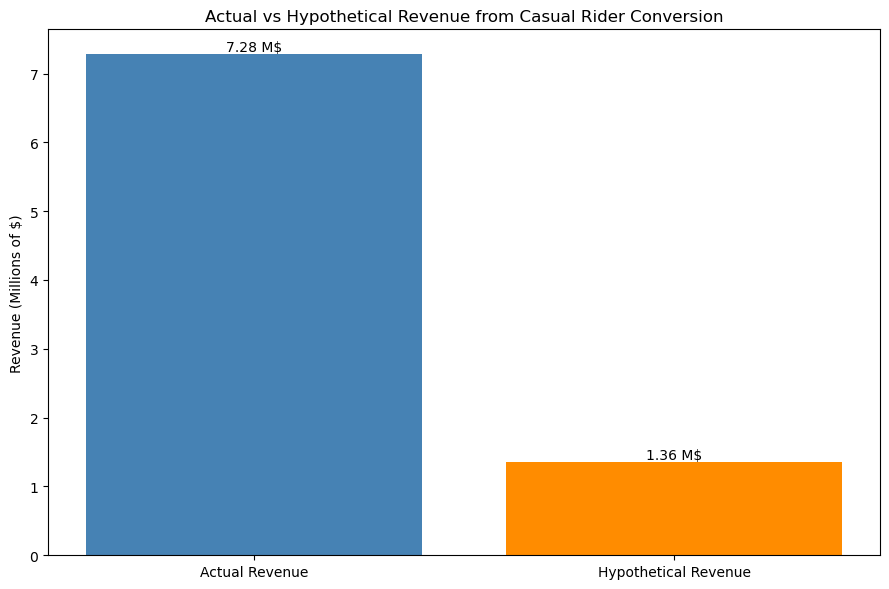

In [20]:
actual_m = actual_total_revenue / 1_000_000
hypothetical_m = hypothetical_total_revenue / 1_000_000

plt.figure(figsize=(9, 6))

bars = plt.bar(
    ["Actual Revenue", "Hypothetical Revenue"],
    [actual_m, hypothetical_m],
    color=["steelblue", "darkorange"]
)

plt.ylabel("Revenue (Millions of $)")
plt.title("Actual vs Hypothetical Revenue from Casual Rider Conversion")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:,.2f} M$",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


### Interpretation:  
The gap between the bars is large and clear.
Cyclistic relies heavily on casual riders for revenue.

# 3. Limitations

This analysis assumes that rider behaviour stays constant when prices change. That assumption simplifies the modelling but limits the conclusions. Research on ride‑share markets shows that demand is price elastic. Riders change their behaviour when prices rise or fall.

Cyclistic’s dataset contains no variation in price. Because of this, the models cannot estimate elasticity or predict how riders would respond to new prices. The pricing corridor shows only what revenue would look like if behaviour stayed the same, which is unlikely in practice.

The results in this notebook should be read as purely mechanistic revenue projection, not a behavioural forecast.

# 4. Future Work: Modelling Price Elasticity

A natural next step is to model how riders respond to price changes. This requires data that varies in price, either through:

- historic price changes

- cross‑market comparisons

- or controlled experiments

Cyclistic could then build a Bayesian elasticity model that estimates how trip frequency, trip duration, and membership conversion respond to different per‑minute rates.

A Bayesian framework can incorporate uncertainty, capture differences across rider types, and update elasticity estimates as new data arrives.

# 5. Strategic Recommendation: Run a Controlled Price Experiment

Cyclistic should run a controlled price experiment. This could involve offering different per‑minute rates at selected stations, in specific neighbourhoods, or during defined time windows. Even a small, well‑designed experiment would generate the variation needed to estimate price elasticity.

The experiment would help Cyclistic answer three critical questions:

- Do lower casual prices increase ridership?

- Do higher casual prices push riders toward membership?

- Where is the true revenue‑maximising or conversion‑maximising price?

Without such an experiment, pricing decisions will continue to rely on mechanical projections rather than behavioural evidence.

# 6. Conclusion

The Bayesian models in this notebook provide a clearer picture of Cyclistic’s current pricing structure. Members receive far more value than they pay for. Casual riders generate most of the company’s revenue. Converting casual riders to members under the current plan would sharply reduce revenue.

The key uncertainty is behavioural. Riders respond to price changes, but Cyclistic has no data on how its riders would respond. A controlled price experiment is the most direct way to gather this information and design a pricing strategy that balances revenue, ridership, and membership growth.